### 读取并清洗数据

In [35]:
import pandas as pd

# 加载 Excel 文件
df = pd.read_excel("用电数据.xlsx", sheet_name="趋势曲线-2025-06-01 000000-2025-07-")

# 重命名列（列名在第1行）
df.columns = [
    "时间", "正向有功电能", "A相电流", "B相电流", "C相电流",
    "A相有功功率", "B相有功功率", "C相有功功率", "视在功率"
]

# 删除表头行
df = df.iloc[1:]

# 转换为正确的数据类型
df["时间"] = pd.to_datetime(df["时间"])
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 查看缺失值
print(df.isnull().sum())


时间        0
正向有功电能    1
A相电流      2
B相电流      1
C相电流      2
A相有功功率    2
B相有功功率    2
C相有功功率    2
视在功率      1
dtype: int64


### 缺失值处理

In [36]:
# 删除含有缺失值的整行
df = df.dropna()

# 查看清洗后的结果
print("缺失值处理后数据行数：", len(df))
print(df.isnull().sum())  # 确保没有空值


缺失值处理后数据行数： 577
时间        0
正向有功电能    0
A相电流      0
B相电流      0
C相电流      0
A相有功功率    0
B相有功功率    0
C相有功功率    0
视在功率      0
dtype: int64


### 数据清洗完整操作

In [39]:
import pandas as pd

# 读取原始数据
df = pd.read_excel("用电数据.xlsx", sheet_name="趋势曲线-2025-06-01 000000-2025-07-")

# 修改列名
df.columns = [
    "时间", "正向有功电能", "A相电流", "B相电流", "C相电流",
    "A相有功功率", "B相有功功率", "C相有功功率", "视在功率"
]

# 删除第一行非数据行
df = df.iloc[1:]

# 转换时间列格式
df["时间"] = pd.to_datetime(df["时间"], errors="coerce")

# 将所有数值列转为数字，非数值转为NaN
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# === 缺失值处理：删除含NaN的行 ===
df = df.dropna()

# 添加新列：负载率
df["负载率"] = df["视在功率"] / 1250

# 保存为新的 Excel 文件
df.to_excel("清洗后用电数据.xlsx", index=False)

# 保存为 CSV（适合文本展示）
df.to_csv("cleaned_data.csv", index=False, encoding="utf-8-sig")

print("✅清洗后的数据已保存为：清洗后用电数据.xlsx")


✅清洗后的数据已保存为：清洗后用电数据.xlsx


### 计算负载率、是否重载

重载时段前5行：
Empty DataFrame
Columns: [时间, 视在功率, 负载率]
Index: []


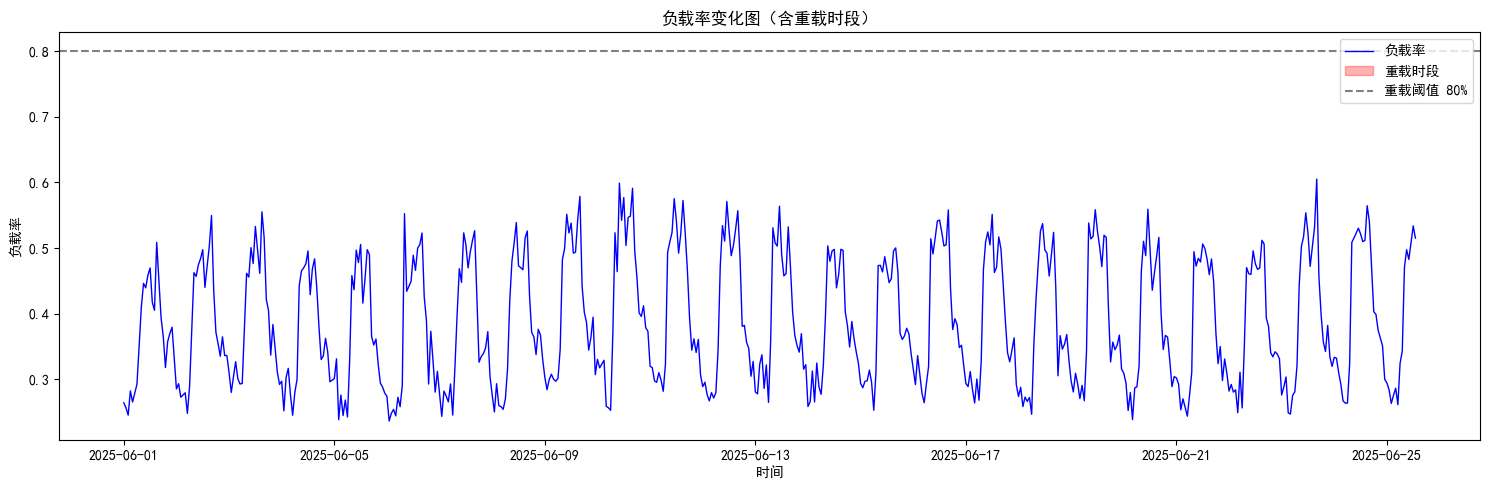

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# 计算负载率（额定功率为1250 kVA）
df["负载率"] = df["视在功率"] / 1250

# 是否重载（负载率 > 80%）
df["是否重载"] = df["负载率"] > 0.8

# 筛选出重载时段
重载时段 = df[df["是否重载"]][["时间", "视在功率", "负载率"]]
print("重载时段前5行：")
print(重载时段.head())

# 设置时间为索引（用于画图）
df.set_index("时间", inplace=True)

# === 可视化：负载率变化图 ===
plt.figure(figsize=(15, 5))
plt.plot(df.index, df["负载率"], label="负载率", color="blue", linewidth=1)

# 标出重载区域（红色）
plt.fill_between(df.index, 0.8, df["负载率"],
                 where=(df["负载率"] > 0.8),
                 color='red', alpha=0.3, label="重载时段")

plt.axhline(0.8, color="gray", linestyle="--", label="重载阈值 80%")
plt.title("负载率变化图（含重载时段）")
plt.xlabel("时间")
plt.ylabel("负载率")
plt.legend()
plt.tight_layout()
plt.show()


### 确认是否真的是全部负载率 < 0.8？

In [42]:
# 显示负载率的描述性统计信息
print("📊 负载率描述性统计：")
print(df["负载率"].describe())

# 检查是否有超过 0.8 的记录（是否存在重载）
重载数量 = (df["负载率"] > 0.8).sum()
总行数 = len(df)

if 重载数量 > 0:
    print(f"\n⚠️ 存在 {重载数量} 条重载记录（占比 {重载数量/总行数:.2%}）")
else:
    print("\n✅ 无重载时段，所有负载率均低于 80%")



📊 负载率描述性统计：
count    577.000000
mean       0.387209
std        0.096708
min        0.236496
25%        0.298696
50%        0.365160
75%        0.478664
max        0.604920
Name: 负载率, dtype: float64

✅ 无重载时段，所有负载率均低于 80%


### 筛选高负载 / 接近重载时段

In [44]:
# 高负载 ≥ 0.6（60%），接近重载 ≥ 0.7（70%）
高负载 = df[df["负载率"] >= 0.6]
接近重载 = df[df["负载率"] >= 0.7]

print(f" 高负载时段数量（≥60%）：{len(高负载)}")
print(f" 接近重载时段数量（≥70%）：{len(接近重载)}")



 高负载时段数量（≥60%）：1
 接近重载时段数量（≥70%）：0


### 可视化负载率并标注高负载/接近重载时段

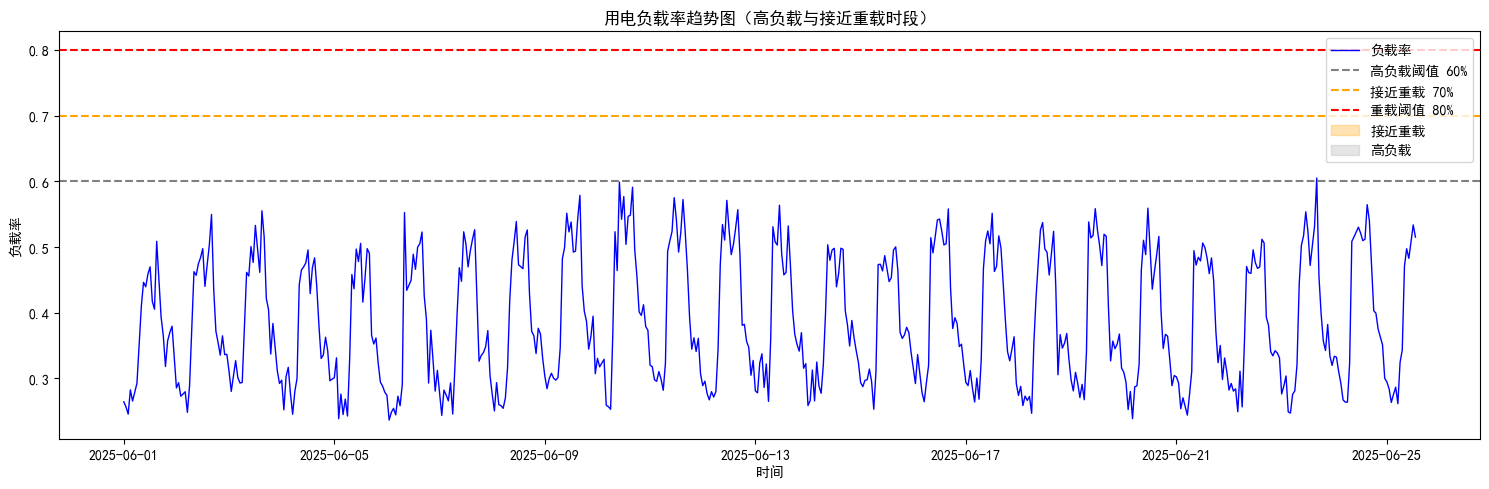

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df.index, df["负载率"], label="负载率", color="blue", linewidth=1)

# 灰线：60%，橙线：70%，红线：80%
plt.axhline(0.6, color='gray', linestyle='--', label='高负载阈值 60%')
plt.axhline(0.7, color='orange', linestyle='--', label='接近重载 70%')
plt.axhline(0.8, color='red', linestyle='--', label='重载阈值 80%')

# 填充：接近重载区域（≥70%）
plt.fill_between(df.index, 0.7, df["负载率"],
                 where=(df["负载率"] >= 0.7),
                 color='orange', alpha=0.3, label="接近重载")

# 填充：高负载区域（≥60%）
plt.fill_between(df.index, 0.6, df["负载率"],
                 where=(df["负载率"] >= 0.6),
                 color='gray', alpha=0.2, label="高负载")

plt.title("用电负载率趋势图（高负载与接近重载时段）")
plt.xlabel("时间")
plt.ylabel("负载率")
plt.legend()
plt.tight_layout()
plt.show()


### 提取每日0点和23点的数据，计算日用电量

In [46]:
# 确保时间列是 datetime 类型
df["日期"] = df.index.date
df["小时"] = df.index.hour

# 分别提取每日0点和23点的正向有功电能
daily_energy = df[df["小时"].isin([0, 23])].groupby("日期")["正向有功电能"].agg(["first", "last"])
daily_energy["日用电量"] = daily_energy["last"] - daily_energy["first"]

print("每日用电量（前几天）：")
print(daily_energy.head())



每日用电量（前几天）：
                first       last     日用电量
日期                                       
2025-06-01  9215940.0  9215940.0      0.0
2025-06-02  9226511.0  9237238.0  10727.0
2025-06-03  9237607.0  9248452.0  10845.0
2025-06-04  9248823.0  9259093.0  10270.0
2025-06-05  9259462.0  9269678.0  10216.0


### 可视化每日用电量趋势

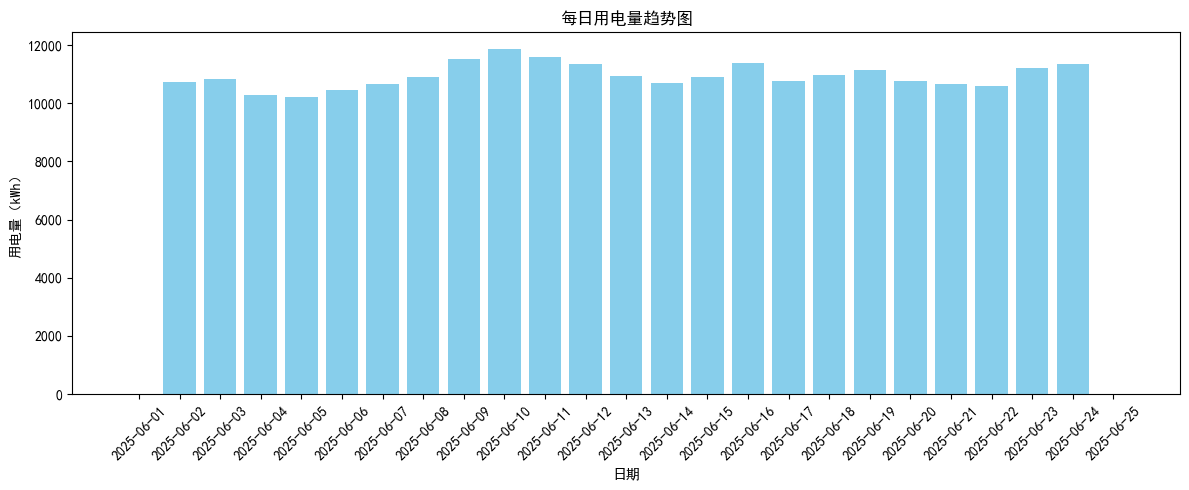

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.bar(daily_energy.index.astype(str), daily_energy["日用电量"], color="skyblue")
plt.xticks(rotation=45)
plt.title("每日用电量趋势图")
plt.xlabel("日期")
plt.ylabel("用电量（kWh）")
plt.tight_layout()
plt.show()


### 找出用电量最大和最小的日期

In [48]:
max_day = daily_energy["日用电量"].idxmax()
min_day = daily_energy["日用电量"].idxmin()

print(f"📈 用电量最大日期：{max_day}，用电量 = {daily_energy.loc[max_day, '日用电量']} kWh")
print(f"📉 用电量最小日期：{min_day}，用电量 = {daily_energy.loc[min_day, '日用电量']} kWh")


📈 用电量最大日期：2025-06-10，用电量 = 11850.0 kWh
📉 用电量最小日期：2025-06-01，用电量 = 0.0 kWh


##### 因为2025-06-01，23点A相电流有缺失，所以该行数据清洗删除了

### 按小时统计每小时用电增量

In [ ]:
# 先按时间排序（确保电能是递增的）
df = df.sort_index()

# 计算每小时用电量（当前电能 - 前一小时电能）
df["小时用电量"] = df["正向有功电能"].diff()

# 去除日期变动处的“跨天跳变”
df["小时差"] = df.index.to_series().diff().dt.total_seconds() / 3600
df.loc[df["小时差"] > 1.1, "小时用电量"] = None  # 跨天或断点设为无效

# 按小时取平均用电量
hourly_usage = df.groupby(df.index.hour)["小时用电量"].mean()

print("各小时平均用电量（单位：kWh）:")
print(hourly_usage.round(2))


各小时平均用电量（单位：kWh）:
时间
0     370.13
1     351.28
2     342.21
3     340.65
4     336.00
5     336.80
6     332.68
7     349.82
8     469.00
9     621.44
10    598.13
11    614.55
12    630.17
13    596.29
14    561.09
15    612.46
16    629.57
17    608.35
18    488.04
19    439.75
20    430.67
21    429.64
22    414.05
23    393.83
Name: 小时用电量, dtype: float64


### 找出最大和最小时间段

In [ ]:
max_hour = hourly_usage.idxmax()
min_hour = hourly_usage.idxmin()

print(f"\n⏰ 用电量最高的小时：{max_hour} 点，平均用电量 = {hourly_usage[max_hour]:.2f} kWh")
print(f"⏰ 用电量最低的小时：{min_hour} 点，平均用电量 = {hourly_usage[min_hour]:.2f} kWh")



⏰ 用电量最高的小时：12 点，平均用电量 = 630.17 kWh
⏰ 用电量最低的小时：6 点，平均用电量 = 332.68 kWh


### 可视化图表（一天内24小时）

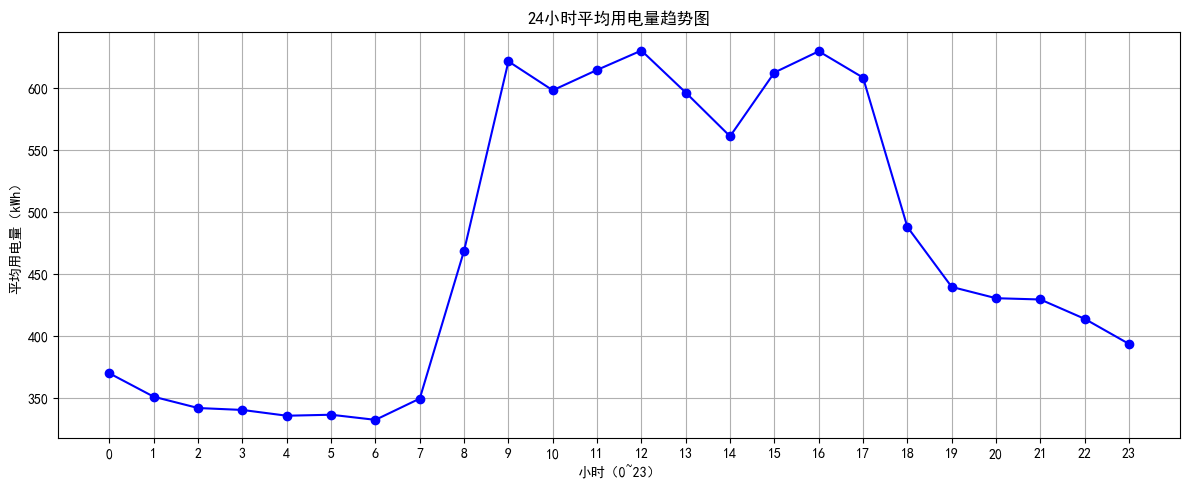

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(hourly_usage.index, hourly_usage.values, marker="o", color="blue")
plt.title("24小时平均用电量趋势图")
plt.xlabel("小时（0~23）")
plt.ylabel("平均用电量（kWh）")
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.show()


### 准备每小时的特征数据

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

# 确保每行有“小时”列
df["小时"] = df.index.hour

# 对每个小时求平均：用作聚类的输入
features = df.groupby("小时")[["A相电流", "B相电流", "C相电流", "视在功率", "负载率"]].mean()

# 进行标准化（避免量纲影响）
scaler = StandardScaler()
scaled = scaler.fit_transform(features)

# 转为 DataFrame 结构（保留小时索引）
scaled_df = pd.DataFrame(scaled, columns=features.columns, index=features.index)


### 使用 KMeans 进行聚类

In [ ]:
# 使用KMeans聚类，设置聚类数为3
kmeans = KMeans(n_clusters=3, random_state=42)
features["cluster"] = kmeans.fit_predict(scaled)

print("聚类结果：")
print(features)


聚类结果：
          A相电流        B相电流         C相电流        视在功率       负载率  cluster
小时                                                                    
0   452.156800  506.450000   607.574800  366.987600  0.293590        2
1   431.973200  495.368800   592.365600  356.195600  0.284956        2
2   426.007917  502.548750   600.732500  358.994583  0.287196        2
3   428.584583  505.375000   593.262917  359.366250  0.287493        2
4   408.463200  477.006400   570.002000  341.775600  0.273420        2
5   417.952400  484.640400   581.004400  347.737600  0.278190        2
6   420.242000  470.611600   576.934000  342.432400  0.273946        2
7   493.668636  589.498182   695.417727  411.410909  0.329129        1
8   679.647600  851.399200  1008.378000  588.565600  0.470852        0
9   708.272000  878.022800  1024.290800  604.089200  0.483271        0
10  738.729130  905.510435  1041.331739  623.950870  0.499161        0
11  759.762083  944.040000  1089.157917  645.727917  0.516582        0


D:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### 可视化聚类结果

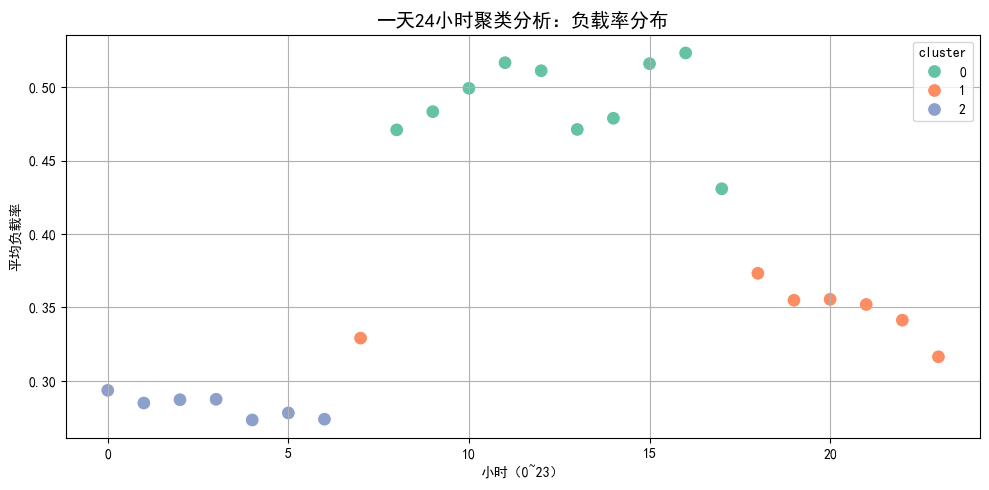

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.scatterplot(data=features, x="小时", y="负载率", hue="cluster", palette="Set2", s=100)

plt.title("一天24小时聚类分析：负载率分布", fontsize=14)
plt.xlabel("小时（0~23）")
plt.ylabel("平均负载率")
plt.grid(True)
plt.tight_layout()
plt.show()




#### 我们将一天24小时划分为3类典型用电模式，聚类结果如下：

##### Cluster 0（高负载时段）：集中出现在白天 9~17 点，用电需求高，电流与视在功率均处于高位；

##### Cluster 1（中等负载时段）：主要在清晨与傍晚，用电负载处于过渡状态；

##### Cluster 2（低负载时段）：集中在深夜凌晨（06点），设备运行负荷最低。

### 整理各类的中心特征和所属小时

In [ ]:
# 1. 各类中心特征平均值
cluster_centers = features.groupby("cluster")[["A相电流", "B相电流", "C相电流", "视在功率", "负载率"]].mean()

# 2. 每类对应的小时
cluster_hours = features.groupby("cluster")["小时"].apply(list)

# 3. 合并汇总
cluster_summary = pd.concat([cluster_centers, cluster_hours.rename("小时列表")], axis=1)
print(cluster_summary)


               A相电流        B相电流         C相电流        视在功率       负载率  \
cluster                                                              
0        723.334031  888.139510  1025.630083  612.597292  0.490078   
1        516.835762  616.396532   719.234599  432.600044  0.346080   
2        426.482871  491.714421   588.839460  353.355662  0.282685   

                                           小时列表  
cluster                                          
0        [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]  
1                   [7, 18, 19, 20, 21, 22, 23]  
2                         [0, 1, 2, 3, 4, 5, 6]  


## 对每类用电模式进行解释
### 根据 负载率、视在功率 的高低，人工命名和解释这3类：

#### Cluster 0：高负载模式
  ##### 负载率高，视在功率、电流均处于高位
  ##### 典型时段：如 9~16 点
  ##### 可能原因：医院门诊时间、设备运行密集、高峰期空调照明开启
  ##### 重点监控 + 节能调度建议

#### Cluster 1：中负载模式
  ##### 中等电流和功率，处于日夜之间的过渡时段
  ##### 典型时段：如 78 点、1722 点
  ##### 可能原因：早晚交接班、非高峰运行、设备开关过程
  ##### 有波动性，适合负载移峰管理

#### Cluster 2：低负载模式
  ##### 电流、负载率均较低
  ##### 典型时段：凌晨 0~6 点
  ##### 可能原因：仅有基础设备运行，如值班照明、急诊设备
  ##### 节能潜力高、负载稳定

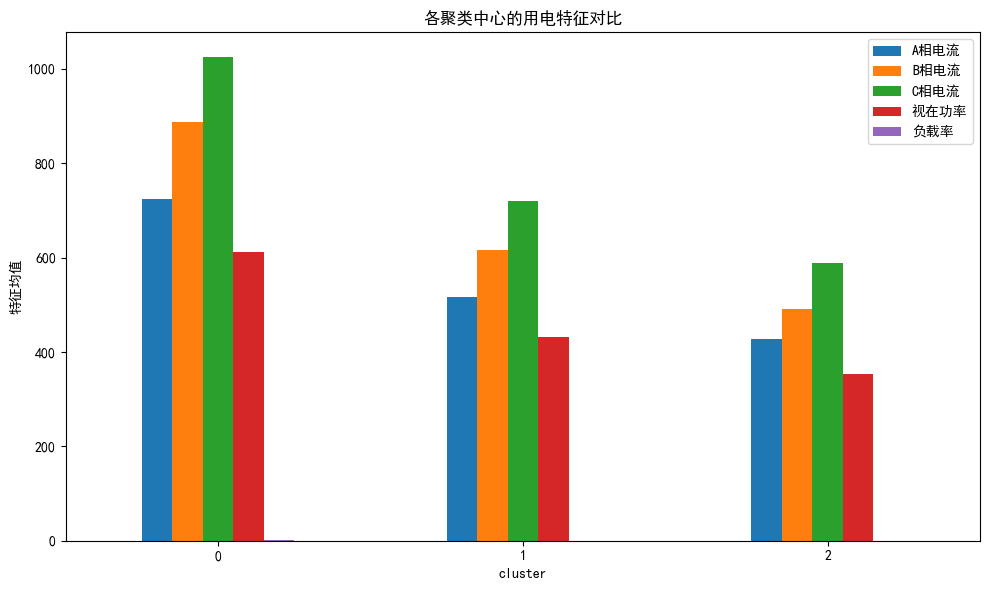

In [65]:
import matplotlib.pyplot as plt

cluster_centers.plot(kind="bar", figsize=(10, 6))
plt.title("各聚类中心的用电特征对比")
plt.ylabel("特征均值")
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
